# Coral Health Classification

by : Dea Kayla

Dataset from https://www.kaggle.com/datasets/asfarhossainsitab/coral-reefs-images

## 1. Data Preprocessing and Augmentation

In this step, I prepare image data for the model.

1.  **Load Data:** I use `ImageDataGenerator` to load images directly from their folders (`train`, `valid`, `test`).
2.  **Normalization:** I **must** rescale all pixel values from the [0, 255] range to [0, 1]. This is a standard practice that helps the model train faster and more stably.
3.  **Data Augmentation:** My training set (9,662 images) is moderately sized. To prevent **overfitting** and make my model more robust, I apply random transformations *only* to the training data. This includes random rotations, zooms, and horizontal flips, which creates new, slightly different versions of the images for the model to learn from.
4.  **Generators:** Finally, `flow_from_directory` creates data "generators" (pipelines) that feed batches of prepared images to the model.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [2]:
BASE_DIR = 'Coral Reef Images/' 

train_dir = os.path.join(BASE_DIR, 'train')
valid_dir = os.path.join(BASE_DIR, 'valid')
test_dir = os.path.join(BASE_DIR, 'test')

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

Data Preprocessing

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi piksel dari [0, 255] ke [0, 1]
    rotation_range=20,      # Rotasi gambar acak s.d. 20 derajat
    width_shift_range=0.2,  # Geser horizontal acak
    height_shift_range=0.2, # Geser vertikal acak
    shear_range=0.2,        # Miringkan gambar
    zoom_range=0.2,         # Zoom acak
    horizontal_flip=True,   # Balik horizontal (sangat umum untuk foto)
    fill_mode='nearest'     # Cara mengisi piksel yg hilang krn augmentasi
)

Data Augmentation

In [5]:
validation_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Train Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    class_mode='binary', 
    shuffle=True       
)

# Validation Generator
validation_generator = validation_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)

# Test Generator
test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Coral Reef Images/train'

In [ ]:
print("\n--- Verifikasi Generator ---")
print(f"Kelas yang terdeteksi (Mapping): {train_generator.class_indices}")
print(f"Total data training    : {train_generator.samples} gambar")
print(f"Total data validasi  : {validation_generator.samples} gambar")
print(f"Total data testing     : {test_generator.samples} gambar")


--- Verifikasi Generator ---
Kelas yang terdeteksi (Mapping): {'Bleached': 0, 'Healthy': 1}
Total data training    : 9662 gambar
Total data validasi  : 463 gambar
Total data testing     : 257 gambar


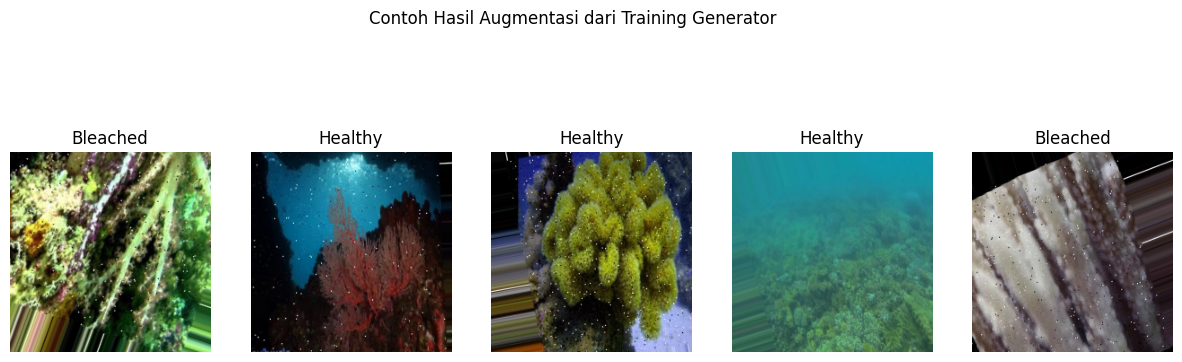

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])

    if labels[i] == 0:
        label_name = "Bleached"
    else:
        label_name = "Healthy"
        
    plt.title(label_name)
    plt.axis('off')

plt.suptitle("Contoh Hasil Augmentasi dari Training Generator")
plt.show()

## 2. Model Architecture: Transfer Learning (ResNet50V2)

For this image classification task, I will use **Transfer Learning**, which is a powerful Neuro Computing technique.

Instead of building a new model from scratch, I use a pre-trained model, **ResNet50V2**, which was already trained on the massive ImageNet dataset (1.4 million images). This model already knows how to detect basic features like edges, shapes, and textures.

My strategy is:
1.  **Load Base Model:** I load ResNet50V2 *without* its final classification layer (`include_top=False`).
2.  **Freeze Base Model:** I "freeze" all the layers of ResNet50V2 (`base_model.trainable = False`). This stops them from being changed during training, saving massive amounts of computation time.
3.  **Add Custom Head:** I add our *own* small classifier on top of the frozen base. This new "head" (GlobalAveragePooling, Dropout, and a final `Dense(1, 'sigmoid')` layer) is the only part of the model that will be trained.

This 'sigmoid' layer is essential for binary classification, as it will output a single probability score between 0 (Bleached) and 1 (Healthy).

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

In [ ]:
base_model.trainable = False

print(f"Total layer di base model: {len(base_model.layers)}")
print("Base model telah di-freeze (trainable = False).")

Total layer di base model: 190
Base model telah di-freeze (trainable = False).


In [ ]:
# 1. Tentukan input
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Hubungkan input ke base model
x = base_model(inputs, training=False)

# 3. Tambahkan layer pooling untuk merangkum fitur
x = GlobalAveragePooling2D()(x)

# 4. Tambahkan layer Dropout untuk mencegah overfitting
x = Dropout(0.3)(x) 

# 5. Tambahkan layer output
outputs = Dense(1, activation='sigmoid')(x)

# 6. Gabungkan menjadi model baru
model = Model(inputs, outputs)

# Tampilkan arsitektur model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy']     
)

In [ ]:
# 1. ModelCheckpoint
checkpoint_path = "coral_model_best.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,    
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# 2. EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,         
    restore_best_weights=True 
)

EPOCHS = 12

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, early_stopping]
)

C:\Users\Dea\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7195 - loss: 0.5458
Epoch 1: val_accuracy improved from None to 0.87041, saving model to coral_model_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - accuracy: 0.8063 - loss: 0.4160 - val_accuracy: 0.8704 - val_loss: 0.3380
Epoch 2/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8789 - loss: 0.2958
Epoch 2: val_accuracy improved from 0.87041 to 0.88985, saving model to coral_model_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.8778 - loss: 0.2922 - val_accuracy: 0.8898 - val_loss: 0.3010
Epoch 3/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8903 - loss: 0.2630
Epoch 3: val_accuracy did not improve from 0.88985
302/302 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.8910 - loss: 0.2638 - val_accuracy: 0.8877 - val_loss: 0.2924
Epoch 4/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8964 - loss: 0.2573
Epoch 4: val_accuracy improved from 0.88985 to 0.89201, saving model to coral_model_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.8966 - loss: 0.2556 - val_accuracy: 0.8920 - val_loss: 0.2855
Epoch 5/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.9000 - loss: 0.2553
Epoch 5: val_accuracy did not improve from 0.89201
302/302 ━━━━━━━━━━━━━━━━━━━━ 281s 930ms/step - accuracy: 0.8986 - loss: 0.2526 - val_accuracy: 0.8920 - val_loss: 0.2797
Epoch 6/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.9006 - loss: 0.2413
Epoch 6: val_accuracy improved from 0.89201 to 0.90065, saving model to coral_model_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9023 - loss: 0.2403 - val_accuracy: 0.9006 - val_loss: 0.2714
Epoch 7/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9055 - loss: 0.2363
Epoch 7: val_accuracy did not improve from 0.90065
302/302 ━━━━━━━━━━━━━━━━━━━━ 275s 911ms/step - accuracy: 0.9043 - loss: 0.2397 - val_accuracy: 0.8985 - val_loss: 0.2792
Epoch 8/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9034 - loss: 0.2383
Epoch 8: val_accuracy did not improve from 0.90065
302/302 ━━━━━━━━━━━━━━━━━━━━ 277s 918ms/step - accuracy: 0.9022 - loss: 0.2417 - val_accuracy: 0.8985 - val_loss: 0.2689
Epoch 9/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9094 - loss: 0.2235
Epoch 9: val_accuracy did not improve from 0.90065
302/302 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.9081 - loss: 0.2272 - val_accuracy: 0.9006 - val_loss: 0.2714
Epoch 10/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9071 - loss: 0.2283
Epoch 10: val_accur

302/302 ━━━━━━━━━━━━━━━━━━━━ 274s 908ms/step - accuracy: 0.9047 - loss: 0.2330 - val_accuracy: 0.9028 - val_loss: 0.2674
Epoch 11/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9033 - loss: 0.2406
Epoch 11: val_accuracy improved from 0.90281 to 0.90713, saving model to coral_model_best.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.9048 - loss: 0.2322 - val_accuracy: 0.9071 - val_loss: 0.2753
Epoch 12/12
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9059 - loss: 0.2329
Epoch 12: val_accuracy did not improve from 0.90713
302/302 ━━━━━━━━━━━━━━━━━━━━ 286s 946ms/step - accuracy: 0.9056 - loss: 0.2356 - val_accuracy: 0.8963 - val_loss: 0.2750


## 3. Model Evaluation and Analysis

The model training stopped after 12 epochs, thanks to our `EarlyStopping` callback. The best model was saved from **Epoch 11**, which had the highest validation accuracy (90.71%).

Now, we will analyze its performance using the loss graphs and, most importantly, the independent **test set**.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
class_indices = train_generator.class_indices
labels = dict((v, k) for k, v in class_indices.items())
print(f"Label mapping: {labels}")

Label mapping: {0: 'Bleached', 1: 'Healthy'}


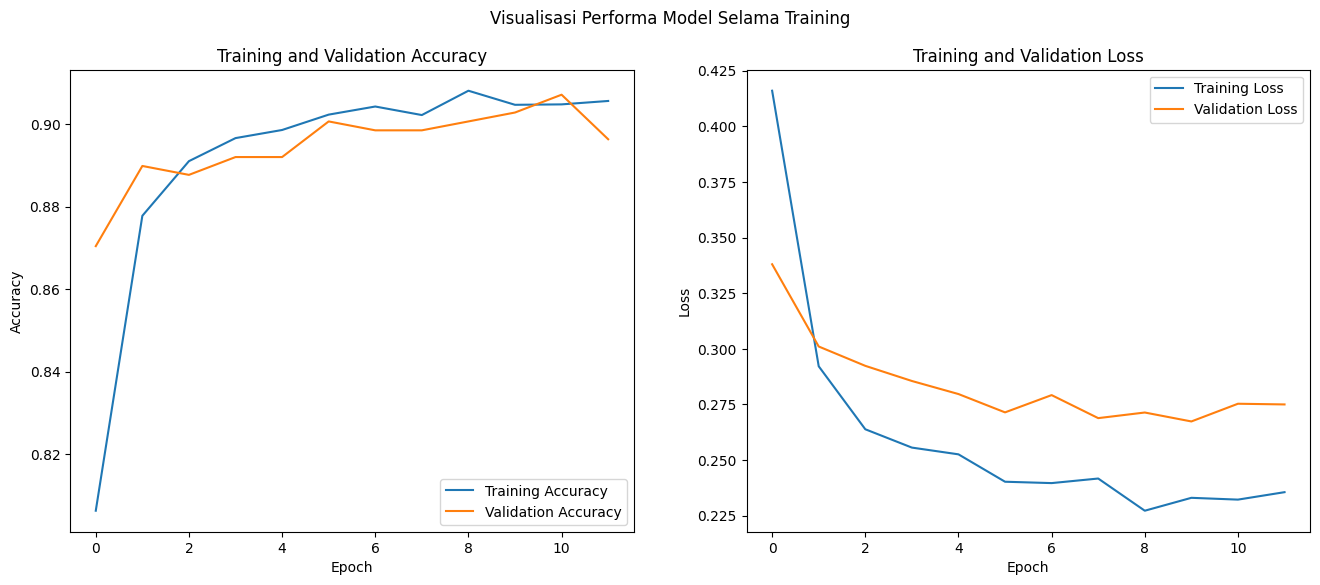

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(16, 6))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("Visualisasi Performa Model Selama Training")
plt.show()

### 3.1. Analysis of Training Graphs

The plots above are **ideal**.
* **Accuracy:** The blue (Training) and orange (Validation) accuracy lines move up together, showing that the model is learning from the training data and also generalizing well to new data.
* **Loss:** The validation loss (orange) consistently decreases along with the training loss. This indicates that our model is **not overfitting**. The use of Data Augmentation and Dropout was successful.

In [ ]:
print(f"Me-load model terbaik dari: {checkpoint_path}")
best_model = load_model(checkpoint_path)

test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f} ({(test_accuracy * 100):.2f}%)")

test_generator.reset()

Y_pred_proba = best_model.predict(
    test_generator, 
    steps=test_generator.samples 
)

Y_pred = (Y_pred_proba > 0.5).astype(int)
Y_true = test_generator.classes

Me-load model terbaik dari: coral_model_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9144 - loss: 0.1976

Test Loss     : 0.1976
Test Accuracy : 0.9144 (91.44%)
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step


In [ ]:
target_names = list(labels.values()) 
print(classification_report(Y_true, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Bleached       0.91      0.93      0.92       135
     Healthy       0.92      0.89      0.91       122

    accuracy                           0.91       257
   macro avg       0.92      0.91      0.91       257
weighted avg       0.91      0.91      0.91       257



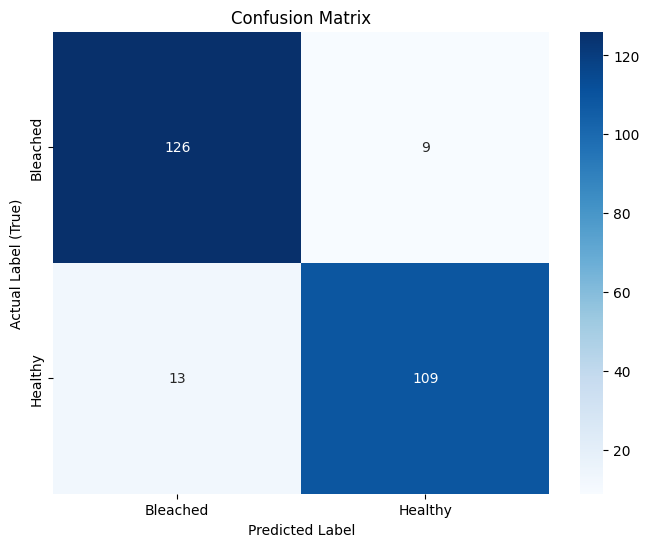

In [ ]:
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=target_names, 
    yticklabels=target_names
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label (True)')
plt.xlabel('Predicted Label')
plt.show()

### 3.2. Analysis of Test Set Performance (Final Result)

This is the most important test of our model.

* **Final Accuracy:** The model achieved a **Test Accuracy of 91.44%**. This is a strong, reliable score.
* **Classification Report:** Both **Precision** (how many "Healthy" predictions were correct) and **Recall** (how many "Healthy" corals did we find) are high, at ~91-92% for both classes. This means the model is balanced.
* **Confusion Matrix Analysis:**
    * **126 True Negatives (TN):** Correctly identified 126 `Bleached` corals.
    * **109 True Positives (TP):** Correctly identified 109 `Healthy` corals.
    * **9 False Positives (FP):** Incorrectly labeled 9 `Bleached` corals as 'Healthy'.
    * **13 False Negatives (FN):** Incorrectly labeled 13 `Healthy` corals as 'Bleached'.

**Conclusion:** The model is highly effective. The small number of errors is balanced, meaning it doesn't have a significant bias towards one class.

# 4. Final Sanity Check: Predicting a Single Image

After evaluating the model on the *entire* test set, I want to perform one final spot check. This code will load the best saved model (`coral_model_best.h5`) and use it to predict a single, specific image from the test folder.

This process involves a few key steps:
1.  **Load Model:** Load the saved `coral_model_best.h5` file using `load_model()`.
2.  **Define Preprocessing Function:** Create a function (`preprocess_single_image`) that exactly replicates the validation/test preprocessing:
    * Load the image and resize it to `(224, 224)`.
    * Convert it to a NumPy array.
    * Rescale the pixel values by dividing by `255.0`.
    * Add a "batch" dimension using `np.expand_dims` (changing the shape from `(224, 224, 3)` to `(1, 224, 224, 3)`), as the model expects a batch of images.
3.  **Predict:** Pass the preprocessed image batch to `model.predict()`.
4.  **Interpret Result:** The model outputs a raw probability (e.g., `0.9793`). I convert this to a human-readable label. Since `'Healthy'` is class `1`, a probability `> 0.5` means the model predicts 'Healthy'.

Me-load model dari coral_model_best.h5...


Model berhasil di-load.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step

--- HASIL PREDIKSI ---
Gambar           : Coral Reef Images/test/Healthy/frame_4920_jpg.rf.afb29e11ac5e0ced16dd6fdc5db9c316.jpg
Probabilitas Mentah: 0.9793
Prediksi         : Healthy
Confidence       : 97.93%


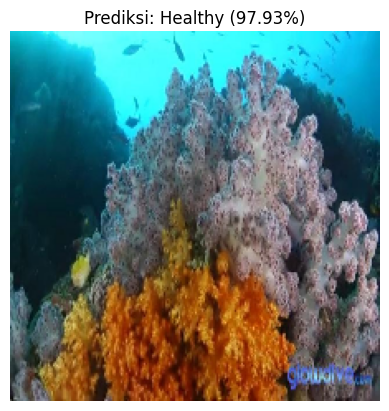

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = "coral_model_best.h5"
IMG_HEIGHT = 224
IMG_WIDTH = 224

class_names = ['Bleached', 'Healthy']

PATH_GAMBAR_TES = "Coral Reef Images/test/Healthy/frame_4920_jpg.rf.afb29e11ac5e0ced16dd6fdc5db9c316.jpg"


# Load Model 
print(f"Me-load model dari {MODEL_PATH}...")
model = load_model(MODEL_PATH)
print("Model berhasil di-load.")

def preprocess_single_image(img_path):
    """
    Me-load dan mem-preprocess satu gambar
    """
    img = load_img(
        img_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    return img, img_batch 

try:
    original_img, processed_img_batch = preprocess_single_image(PATH_GAMBAR_TES)
    prediction = model.predict(processed_img_batch)
    

    probabilitas = prediction[0][0]

    if probabilitas > 0.5:
        pred_label = "Healthy"
        confidence = probabilitas * 100
    else:
        pred_label = "Bleached"
        confidence = (1 - probabilitas) * 100
        
    print("\n--- HASIL PREDIKSI ---")
    print(f"Gambar           : {PATH_GAMBAR_TES}")
    print(f"Probabilitas Mentah: {probabilitas:.4f}")
    print(f"Prediksi         : {pred_label}")
    print(f"Confidence       : {confidence:.2f}%")
    
    plt.imshow(original_img)
    plt.title(f"Prediksi: {pred_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"\nERROR: File tidak ditemukan di '{PATH_GAMBAR_TES}'")
    print("Pastikan Anda sudah mengganti 'PATH_GAMBAR_TES' dengan benar.")
except Exception as e:
    print(f"\nTerjadi error: {e}")

### Prediction Result

As shown in the output, the model correctly predicted the test image (`.../Healthy/frame_4920...`) as **'Healthy'** with a very high **97.93% confidence**.

This confirms that the model is loaded correctly, the preprocessing pipeline is working, and the model is highly confident in its (correct) prediction.